Assuming cache file is valid


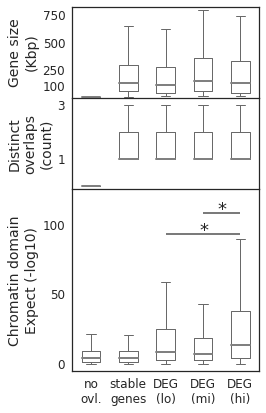

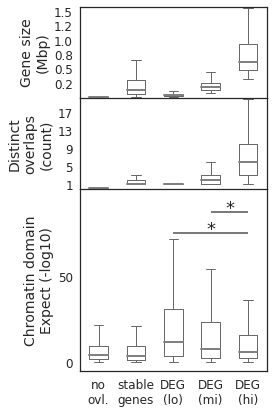

In [1]:
%matplotlib inline

import os as os
import collections as col
import itertools as itt
import pickle as pck
import json as js
import time as ti

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import numpy as np
import numpy.random as rng
import scipy.stats as stats
import pandas as pd
import seaborn as sns

# What does this do?
# Plot boxplots of HSP scores
# (not) overlapping with genes

date = '20180922'

run_plot_hsp_gene_ovl = True

save_figures = True
diss_version = True

journal = 'bmc_genbio'
res = 'print_lo'
fig_sizes = js.load(open('/home/pebert/work/code/mpggit/statediff/annotation/misc/fig_sizes.json'))
fig_sizes = fig_sizes[journal]
resolution = fig_sizes['resolution']

sns.set(style='white',
        font_scale=1.5,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

segmentations = ['cmm18', 'ecs18', 'ecs10']
scorings = ['penem', 'ordem', 'penrep', 'ordrep']

fhgfs_base = '/TL/deep/fhgfs/projects/pebert/thesis/projects/statediff'
cache_dir = os.path.join(fhgfs_base, 'caching/notebooks')

hsp_gene_ovl_folder = os.path.join(fhgfs_base, 'bedtools/deep/isect_hsp_gene')

base_out = '/TL/deep-external01/nobackup/pebert/cloudshare/mpiinf/phd/chapter_projects/statediff'
fig_supp = os.path.join(base_out, 'figures', 'pub', 'supp')
fig_main = os.path.join(base_out, 'figures', 'pub', 'main')
fig_collect = os.path.join(base_out, 'figures', 'pub', 'collection')
fig_diss = '/home/pebert/work/code/mpggit/dissertation/Figures/diffchrom'
                   

def extract_table_header(fpath):
    
    gene_header = 'chrom start end name log2fc strand symbol padj baseMean is_de'
    gene_header = gene_header.split()
    gene_header = ['gene_' + g for g in gene_header]
    gene_header += ['overlap']
    
    with open(fpath, 'r') as table:
        hd = table.readline().strip('#').strip().split('\t')
        hd = ['hsp_' + h for h in hd]
    hd += gene_header
    return hd
        
    return hd
    

def count_segment_overlaps(data, grouping):
    
    overlaps = []
    for g in data[grouping].unique():
        hsp_counts = col.Counter(data.loc[data[grouping] == g, 'gene_name'])
        oc = col.Counter(hsp_counts.values())
        s = pd.DataFrame([oc[i] for i in sorted(oc.keys())],
                          index=[i for i in sorted(oc.keys())],
                          columns=[g])
        overlaps.append(s)
    overlaps = pd.concat(overlaps, axis=1, ignore_index=False, sort=False)
    overlaps.fillna(0, inplace=True)
    overlaps = overlaps.astype(np.int32)
    overlaps.index.name = 'distinct'
    return overlaps


def assign_percentile_groups(data, valtype, group):
    
    lower, upper = np.percentile(data[valtype], [40, 80])
    data.loc[data[valtype] < lower, group] = 1
    data.loc[data[valtype] > upper, group] = 3
    data.loc[data[group] == -1, group] = 2
    return data
    
    
def read_overlap_table(fpath, header=None):
    
    if header is None:
        header = extract_table_header(fpath)
    
    df = pd.read_csv(fpath, skiprows=1,delimiter='\t',
                     names=header, header=None)

    exp_nonzero_min = df.loc[df['hsp_segment_expect'] > 0, 'hsp_segment_expect'].min()
    df.loc[df['hsp_segment_expect'] == 0, 'hsp_segment_expect'] = exp_nonzero_min
    df['expect'] = -1 * np.log10(df['hsp_segment_expect'])
    
    ovl_genes = df.loc[df['overlap'] > 0, :].copy()
    ovl_genes['gene_is_de'] = ovl_genes['gene_is_de'].astype(np.int8)
    ovl_genes['gene_log2fc'] = ovl_genes['gene_log2fc'].astype(np.float32)
    
    singletons = df.loc[df['overlap'] == 0, :].copy()
    singletons['gene_length'] = 0
    
    singletons = singletons[['expect', 'gene_length']]
    singletons['de_group'] = -1
    singletons['len_group'] = -1
    singletons['gene_is_de'] = -1
    
    ovl_genes['gene_length'] = ovl_genes['gene_end'] - ovl_genes['gene_start']
    ovl_genes['de_group'] = -1
    ovl_genes['len_group'] = -1
    
    de_genes = ovl_genes.loc[ovl_genes['gene_is_de'] > 0, :].copy()
    st_genes = ovl_genes.loc[ovl_genes['gene_is_de'] < 1, :].copy()
    st_genes['de_group'] = 0
    st_genes['len_group'] = 0
    
    de_genes = assign_percentile_groups(de_genes, 'gene_log2fc', 'de_group')
    de_genes = assign_percentile_groups(de_genes, 'gene_length', 'len_group')
    
    de_hits_fc = count_segment_overlaps(de_genes, 'de_group')
    de_hits_fc.columns = ['deg_fc_' + str(c) for c in de_hits_fc.columns]
    de_hits_len = count_segment_overlaps(de_genes, 'len_group')
    de_hits_len.columns = ['deg_len_' + str(c) for c in de_hits_len.columns]
    
    all_hits = de_hits_fc.merge(de_hits_len, on='distinct', how='outer')
    
    # for stable genes, both grouping are identical
    st_hits = count_segment_overlaps(st_genes, 'len_group')
    st_hits.columns = ['stg_any_' + str(c) for c in st_hits.columns]
    
    all_hits = all_hits.merge(st_hits, on='distinct', how='outer')
    all_hits.fillna(0, inplace=True)
    all_hits.sort_index(inplace=True)
    all_hits = all_hits.astype(np.int32)
        
    ovl_genes = pd.concat([de_genes, st_genes], axis=0, ignore_index=False, sort=False)
    ovl_genes = ovl_genes[['expect', 'gene_length', 'de_group', 'len_group', 'gene_is_de']]
    
    segments = pd.concat([ovl_genes, singletons], ignore_index=False,
                         axis=0, sort=False)
        
    return segments, all_hits, header  
    
    
def cache_hsp_gene_overlaps(rootfolder, cache_file):
    """
    """
        
    ovl_header = None
    
    for tsv in sorted(os.listdir(rootfolder)):
        if not tsv.endswith('.tsv'):
            continue
        fpath = os.path.join(rootfolder, tsv)
        parts = tsv.split('.')[0].split('_')
        seg, score = parts[3], parts[-1]
        comp = parts[4] + '_vs_' + parts[6]
        segments, hits, ovl_header = read_overlap_table(fpath, ovl_header)
        
        cache_path = os.path.join(seg, score, comp)
        with pd.HDFStore(cache_file, 'a') as hdf:
            hdf.put(cache_path + '/segments', segments, format='fixed')
            hdf.put(cache_path + '/overlaps', hits, format='fixed')

    return cache_file


def make_ovl_array(data, group, member):
    concats = []
    
    if member == 0:
        column = 'stg_any_0'
    elif group == 'de_group':
        column = 'deg_fc_' + str(member)
    elif group == 'len_group':
        column = 'deg_len_' + str(member)
    else:
        raise ValueError('Unexpected combination: {} / {}'.format(group, member))
    
    counts = data[column]
    for elem, rep in counts.items():
        concats.append(np.repeat([elem], rep))
    concats = np.concatenate(concats)
    return concats


def prepare_plot_data(fobj, load_paths, plot_group):
    
    collect_exp = col.defaultdict(list)
    collect_len = col.defaultdict(list)
    collect_ovl = col.defaultdict(list)
    groupings = [-1, 0, 1, 2, 3]
    for k in load_paths:
        data = fobj[k]
        if k.endswith('/segments'):
            for x in groupings:
                collect_exp[x].append(data.loc[data[plot_group] == x, 'expect'].values)
                if x > -1:
                    collect_len[x].append(data.loc[data[plot_group] == x, 'gene_length'].values)
        else:
            # skip over empty
            for x in groupings[1:]:
                collect_ovl[x].append(make_ovl_array(data, plot_group, x))
    expect = [np.concatenate(collect_exp[x]) for x in groupings]
    overlaps = [np.concatenate(collect_ovl[x]) for x in groupings[1:]]
    overlaps = [np.array([0])] + overlaps
    lengths = [np.concatenate(collect_len[x]) for x in groupings[1:]]
    lengths = [np.array([0])] + lengths
    return lengths, overlaps, expect


def create_boxplot(top_values, mid_values, bottom_values, xlabels, fkey, save_diss):
    """
    """
    boxcolor = 'dimgrey'
    medcolor = 'grey'
    median_props = {'color': medcolor, 'linewidth': 2}
    box_props = {'color': boxcolor, 'linewidth': 1}
    whisker_props = {'color': boxcolor, 'linewidth': 1}
    cap_props = {'color': boxcolor, 'linewidth': 1}
                
    fig, (ax_top, ax_mid, ax_bottom) = plt.subplots(figsize=fig_sizes['one_col']['double'],
                                                    nrows=3, ncols=1, sharex=True, sharey=False,
                                                    gridspec_kw={'height_ratios': [1, 1, 2]})
    
    plt.subplots_adjust(hspace=0.005)
    
    # plot RGB feature length distribution
    #top_values = [top_values[0]] + [np.log10(x) for x in top_values[1:]]
    bb_len = ax_top.boxplot(top_values, sym="", labels=None,
                            medianprops=median_props, boxprops=box_props,
                            whiskerprops=whisker_props, capprops=cap_props)
#     ax_top.axhline(y=1000, xmin=0, xmax=1, zorder=0,
#                    color='black', ls='dashed', lw=1)
        
    top_max_y = 0
    for cap in bb_len['caps']:
        if max(cap.get_ydata()) > top_max_y:
            top_max_y = max(cap.get_ydata())
    ax_top.set_ylim(-10000, np.ceil(top_max_y) + 25000)
    if top_max_y > 1e6:
        div_factor = 1000000
        top_ylabel = 'Gene size\n(Mbp)'
    else:
        div_factor = 1000
        top_ylabel = 'Gene size\n(Kbp)'
    ax_top.set_ylabel(top_ylabel, fontsize=14)
    if top_max_y < 100000:
        top_yticks = np.arange(0, top_max_y, step=25000, dtype=np.int32)
    else:
        top_yticks = np.arange(0, top_max_y, step=250000, dtype=np.int32)
    if top_max_y > 1e6:
        top_yticks = top_yticks[1:]
    else:
        top_yticks = np.concatenate([np.array([100000], dtype=np.int32), top_yticks[1:]])
    ax_top.set_yticks(top_yticks)
    if div_factor > 1000:
        ax_top.set_yticklabels(list(map(str, (top_yticks / div_factor).round(1))), fontsize=12)
    else:
        ax_top.set_yticklabels(list(map(str, top_yticks // div_factor)), fontsize=12)
    ax_top.spines['bottom'].set_visible(False)
    
    if not save_diss:
        fig_title = ax_top.set_title(fkey, fontsize=16)
        fig_title.set_position((0.025, 1.01))
    
    # plot HSP gene overlaps
    bb_ovl = ax_mid.boxplot(mid_values, sym="", labels=None,
                            medianprops=median_props, boxprops=box_props,
                            whiskerprops=whisker_props, capprops=cap_props)
#     ax_mid.axhline(y=0.9, xmin=0, xmax=1, zorder=0,
#                    color='black', ls='dashed', lw=1)
    
    mid_max_y = 0
    for cap in bb_ovl['caps']:
        if max(cap.get_ydata()) > mid_max_y:
            mid_max_y = max(cap.get_ydata())
    mid_max_y = mid_max_y + 0.25
    ax_mid.set_ylim(-0.1, mid_max_y)
    
    if mid_max_y < 10:
        mid_yticks = np.arange(1, mid_max_y, step=2, dtype=np.int8)
    else:
        mid_yticks = np.arange(1, mid_max_y, step=4, dtype=np.int8)
    ax_mid.set_yticks(mid_yticks)
    ax_mid.set_yticklabels(list(map(str, mid_yticks)), fontsize=12)
    ax_mid.set_ylabel('Distinct\noverlaps\n(count)', fontsize=14)
    
    ax_mid.spines['bottom'].set_visible(False)
    
    # extract individual values for stat test
    noovl, stable, low, middle, high = bottom_values
    mwu = stats.mannwhitneyu
    
    hi_to_mid = mwu(high, middle, alternative='two-sided')[1]
    hi_to_low = mwu(high, low, alternative='two-sided')[1]
    no_to_stab = mwu(noovl, stable, alternative='two-sided')[1]
        
    # plot HSP expects
    bb_score = ax_bottom.boxplot(bottom_values, sym="", labels=None,
                                 medianprops=median_props, boxprops=box_props,
                                 whiskerprops=whisker_props, capprops=cap_props)
    bottom_max_y = 0
    for cap in bb_score['caps']:
        if max(cap.get_ydata()) > bottom_max_y:
            bottom_max_y = max(cap.get_ydata())
    bottom_max_y = (bottom_max_y // 25) * 25 + 50
    ax_bottom.set_ylim(-5, bottom_max_y)
    
    if bottom_max_y < 100:
        bottom_yticks = np.arange(0, bottom_max_y, step=20, dtype=np.int16)
    else:
        bottom_yticks = np.arange(0, bottom_max_y, step=50, dtype=np.int16)
    ax_bottom.set_yticks(bottom_yticks)
    ax_bottom.set_yticklabels(list(map(str, bottom_yticks)), fontsize=12)
    ax_bottom.set_ylabel('Chromatin domain\nExpect (-log10)', fontsize=14)
    
    ax_bottom.set_xticklabels(xlabels, fontsize=12, ha='center')
    
    if not fkey.startswith('S'):
        ax_bottom.hlines([93, 108], [3, 4], [5, 5], color='dimgrey')
        ax_bottom.text(3.9, 92, '*' if hi_to_low < 0.01 else 'n.s.')
        ax_bottom.text(4.4, 107, '*' if hi_to_mid < 0.01 else 'n.s.')
    else:
        ax_bottom.hlines([75, 87], [3, 4], [5, 5], color='dimgrey')
        ax_bottom.text(3.9, 74, '*' if hi_to_low < 0.01 else 'n.s.')
        ax_bottom.text(4.4, 86, '*' if hi_to_mid < 0.01 else 'n.s.')
    
    return fig, []          


def plot_hsp_gene_ovl():
    cache_file = os.path.join(cache_dir, '{}_plot_hsp-ovl-gene.h5'.format(date))
    if not os.path.isfile(cache_file):
        _ = cache_hsp_gene_overlaps(hsp_gene_ovl_folder, cache_file)
    elif os.stat(cache_file).st_size < 1e6:
        _ = cache_hsp_gene_overlaps(hsp_gene_ovl_folder, cache_file)
    else:
        print('Assuming cache file is valid')

    with pd.HDFStore(cache_file, 'r') as hdf:
        cached_keys = list(hdf.keys())
        for seg in segmentations:
            if seg != 'cmm18':
                continue
            for score in scorings:
                if score != 'penem':
                    continue
                load_keys = [k for k in cached_keys if seg in k and score in k]
                
                lengths, overlaps, expect = prepare_plot_data(hdf, load_keys, 'de_group')
                fk = '8'
                x_labels = ['no\novl.', 'stable\ngenes', 'DEG\n(lo)', 'DEG\n(mi)', 'DEG\n(hi)']
                fig, exart = create_boxplot(lengths, overlaps, expect, x_labels, fk, diss_version)
                
                if save_figures:
                    outname = 'fig_{}_hsp-gene-ovl_DEG_{}_{}'.format(fk, seg, score)
                    outfolder = fig_main
                    if diss_version:
                        outfolder = fig_diss
                    
                    out_pdf = os.path.join(outfolder, outname + '.pdf')
                    fig.savefig(out_pdf, bbox_inches='tight', extra_artists=exart)
                    
                    if not diss_version:
                        out_png = os.path.join(outfolder, outname + '.png')
                        fig.savefig(out_png, bbox_inches='tight', extra_artists=exart, dpi=resolution[res])
                
                
                lengths, overlaps, expect = prepare_plot_data(hdf, load_keys, 'len_group')
                fk = 'S5'
                x_labels = ['no\novl.', 'stable\ngenes', 'DEG\n(lo)', 'DEG\n(mi)', 'DEG\n(hi)']
                fig, exart = create_boxplot(lengths, overlaps, expect, x_labels, fk, diss_version)
                
                if save_figures:
                    outname = 'fig_{}_hsp-gene-ovl_LEN_{}_{}'.format(fk, seg, score)
                    outfolder = fig_supp
                    if diss_version:
                        outfolder = fig_diss
                    
                    out_pdf = os.path.join(outfolder, outname + '.pdf')
                    fig.savefig(out_pdf, bbox_inches='tight', extra_artists=exart)
                    
                    if not diss_version:
                        out_png = os.path.join(outfolder, outname + '.png')
                        fig.savefig(out_png, bbox_inches='tight', extra_artists=exart, dpi=resolution[res])

    return 0



    
if run_plot_hsp_gene_ovl:
    plot_hsp_gene_ovl()
